**Chapter 14 – Recurrent Neural Networks**

_This notebook contains all the sample code and solutions to the exercices in chapter 14._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import tensorflow as tf

# Basic RNNs

## Manual RNN

In [3]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.82053208  0.99431098 -0.99946314  0.9865402  -0.89121401]
 [ 0.10393736  1.         -1.          0.99997586 -0.99995434]
 [ 0.87802321  1.         -1.          0.99999994 -1.        ]
 [ 0.99999923 -0.07158625 -0.55363363 -0.99990493 -0.55132049]]


In [6]:
print(Y1_val)

[[ 0.99977911  1.         -1.          0.99999851 -1.        ]
 [-0.49182287 -0.63029516  0.96565855 -0.02148083  0.21879137]
 [ 0.9952867   1.         -0.9999947   0.99873829 -0.99993926]
 [ 0.96052271  0.99886537 -0.7533018   0.06383554 -0.85634291]]


## Using `rnn()`

In [7]:
tf.reset_default_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [8]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [9]:
Y0_val

array([[ 0.68331969, -0.78789645, -0.91668612, -0.94697189, -0.24038485],
       [ 0.99775273, -0.9506833 , -0.99979204, -0.99975032, -0.53510815],
       [ 0.99998641, -0.98928219, -0.99999952, -0.99999881, -0.73949718],
       [ 0.99957275,  0.99909806,  0.32584012,  0.93206716,  0.84370828]], dtype=float32)

In [10]:
Y1_val

array([[ 0.99999291, -0.36171386, -0.99999785, -0.99996597, -0.00428927],
       [-0.41839153,  0.75096804,  0.606565  ,  0.67534345,  0.59465897],
       [ 0.99926353,  0.54629689, -0.99900544, -0.9924041 ,  0.1139629 ],
       [ 0.89085555, -0.8939994 , -0.89453429, -0.93726897, -0.63662177]], dtype=float32)

In [11]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph())

## Packing sequences

In [13]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

In [14]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [15]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[ 0.99999988  1.         -0.92499006  0.99976337  0.99848008]
 [-0.35472792  0.71584183 -0.71373397  0.07423807  0.82909638]
 [ 0.9999674   0.99999803 -0.88509911  0.99682868  0.99839389]
 [ 0.99848074  0.99611902  0.36314142  0.99215239  0.95797563]]


## Using `dynamic_rnn()`

In [16]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [17]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    print("outputs =", outputs.eval(feed_dict={X: X_batch}))

outputs = [[[ 0.62797421  0.30141702 -0.44933137  0.26236424 -0.51391608]
  [-0.9057309  -0.99141216  0.85657239 -0.99995953 -0.9993754 ]]

 [[ 0.29503232 -0.67023116 -0.30630386 -0.88455033 -0.97637779]
  [-0.74294037  0.60441327 -0.08187051  0.76437837 -0.79939926]]

 [[-0.12919907 -0.95900756 -0.14796644 -0.99562371 -0.99911046]
  [-0.9955582  -0.97180027  0.50988579 -0.9849022  -0.99946135]]

 [[-0.9996137  -0.90426421  0.99914223 -0.99596131 -0.99996263]
  [-0.99554646 -0.97491413 -0.05848801 -0.36693698 -0.99495977]]]


In [18]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [19]:
tf.reset_default_graph()

n_steps = 2
n_inputs = 3
n_neurons = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, sequence_length=seq_length, dtype=tf.float32)

init = tf.global_variables_initializer()

In [20]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [21]:
print(outputs_val)

[[[-0.6111083   0.49218178  0.8701691  -0.04231749  0.54580343]
  [-0.99996614 -0.99676019  0.99999988 -0.99485856  0.6408028 ]]

 [[-0.9907124  -0.30499423  0.99963558 -0.75243163  0.79337811]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.9998197  -0.82394147  0.99999905 -0.95748097  0.91355109]
  [-0.9996509  -0.99599117  0.99998784 -0.99218011  0.57273889]]

 [[-0.99922258 -0.99998683  0.99476534 -0.01298772  0.37090829]
  [-0.89854306 -0.97039658  0.99201375 -0.83898473  0.58962703]]]


In [22]:
print(states_val)

[[-0.99996614 -0.99676019  0.99999988 -0.99485856  0.6408028 ]
 [-0.9907124  -0.30499423  0.99963558 -0.75243163  0.79337811]
 [-0.9996509  -0.99599117  0.99998784 -0.99218011  0.57273889]
 [-0.89854306 -0.97039658  0.99201375 -0.83898473  0.58962703]]


## Training a sequence classifier

In [23]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.variable_scope("rnn", initializer=tf.contrib.layers.variance_scaling_initializer()):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [25]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.973333 Test accuracy: 0.8671
1 Train accuracy: 0.946667 Test accuracy: 0.9438
2 Train accuracy: 0.94 Test accuracy: 0.944
3 Train accuracy: 0.953333 Test accuracy: 0.9541
4 Train accuracy: 0.98 Test accuracy: 0.9585
5 Train accuracy: 0.966667 Test accuracy: 0.9643
6 Train accuracy: 0.966667 Test accuracy: 0.9639
7 Train accuracy: 0.973333 Test accuracy: 0.9648
8 Train accuracy: 0.973333 Test accuracy: 0.9634
9 Train accuracy: 0.98 Test accuracy: 0.9637
10 Train accuracy: 0.98 Test accuracy: 0.9622
11 Train accuracy: 0.96 Test accuracy: 0.9658
12 Train accuracy: 0.986667 Test accuracy: 0.9704
13 Train accuracy: 1.0 Test accuracy: 0.9685
14 Train accuracy: 0.966667 Test accuracy: 0.969
15 Train accuracy: 0.993333 Test accuracy: 0.9724
16 Train accuracy: 0.993333 Test accuracy: 0.9746
17 Train accuracy: 0.986667 Test accuracy: 0.9657
18 Train accuracy: 0.986667 Test accuracy: 0.9734
19 Train accuracy: 0.986667 Test accuracy: 0.9739
20 Train accuracy: 0.98 Test accuracy

# Multi-layer RNN

In [26]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons1 = 150
n_neurons2 = 100
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

hidden1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons1, activation=tf.nn.relu)
hidden2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons2, activation=tf.nn.relu)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([hidden1, hidden2])
outputs, states_tuple = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
states = tf.concat(axis=1, values=states_tuple)
logits = fully_connected(states, n_outputs, activation_fn=None)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [27]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.94 Test accuracy: 0.9272
1 Train accuracy: 0.986667 Test accuracy: 0.9504
2 Train accuracy: 0.98 Test accuracy: 0.9667
3 Train accuracy: 0.98 Test accuracy: 0.9672
4 Train accuracy: 0.98 Test accuracy: 0.9706
5 Train accuracy: 0.973333 Test accuracy: 0.9737
6 Train accuracy: 0.973333 Test accuracy: 0.9725
7 Train accuracy: 0.993333 Test accuracy: 0.9774
8 Train accuracy: 0.993333 Test accuracy: 0.9795
9 Train accuracy: 0.98 Test accuracy: 0.9748
10 Train accuracy: 0.986667 Test accuracy: 0.9799
11 Train accuracy: 0.98 Test accuracy: 0.9782
12 Train accuracy: 0.973333 Test accuracy: 0.9823
13 Train accuracy: 0.98 Test accuracy: 0.9795
14 Train accuracy: 0.986667 Test accuracy: 0.9814
15 Train accuracy: 0.993333 Test accuracy: 0.9787
16 Train accuracy: 0.993333 Test accuracy: 0.9757
17 Train accuracy: 0.98 Test accuracy: 0.9801
18 Train accuracy: 1.0 Test accuracy: 0.9813
19 Train accuracy: 0.993333 Test accuracy: 0.9838
20 Train accuracy: 0.993333 Test accuracy: 0.98

# Time series

In [28]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


/home/ageron/dev/py/envs/mltst/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


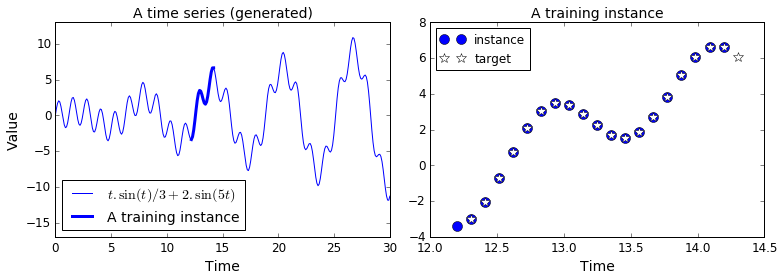

In [29]:
t = np.linspace(t_min, t_max, (t_max - t_min) // resolution)

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [30]:
X_batch, y_batch = next_batch(1, n_steps)

In [31]:
np.c_[X_batch[0], y_batch[0]]

array([[ 0.3266291 , -0.97081587],
       [-0.97081587, -2.09298955],
       [-2.09298955, -2.84017944],
       [-2.84017944, -3.10464787],
       [-3.10464787, -2.89622372],
       [-2.89622372, -2.33910087],
       [-2.33910087, -1.64063575],
       [-1.64063575, -1.03979198],
       [-1.03979198, -0.74786335],
       [-0.74786335, -0.89599678],
       [-0.89599678, -1.50237198],
       [-1.50237198, -2.46708161],
       [-2.46708161, -3.59597343],
       [-3.59597343, -4.64762444],
       [-4.64762444, -5.39195331],
       [-5.39195331, -5.66612695],
       [-5.66612695, -5.41407933],
       [-5.41407933, -4.69997176],
       [-4.69997176, -3.69230347],
       [-3.69230347, -2.6225661 ]])

## Using an `OuputProjectionWrapper`

In [32]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [33]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 22584.6
100 	MSE: 786.52
200 	MSE: 427.682
300 	MSE: 213.502
400 	MSE: 154.842
500 	MSE: 83.3785
600 	MSE: 56.379
700 	MSE: 57.2104
800 	MSE: 64.23
900 	MSE: 62.5516
[[[-3.51760769]
  [-2.56235027]
  [-1.24227786]
  [ 0.61775202]
  [ 2.14323711]
  [ 2.98960495]
  [ 3.46584606]
  [ 3.40469408]
  [ 2.77786183]
  [ 2.13859129]
  [ 1.71483374]
  [ 1.59727895]
  [ 1.89304471]
  [ 2.69040084]
  [ 3.86570907]
  [ 5.14488888]
  [ 6.14800119]
  [ 6.62051868]
  [ 6.62806034]
  [ 6.06975651]]]


Saving figure time_series_pred_plot


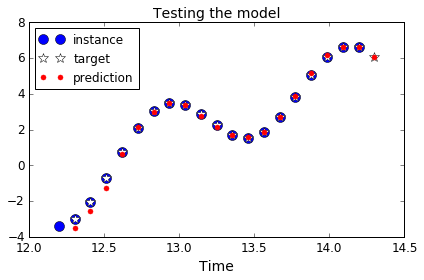

In [34]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [35]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [36]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    print(y_pred)

0 	MSE: 17691.8
100 	MSE: 687.35
200 	MSE: 267.795
300 	MSE: 125.488
400 	MSE: 71.624
500 	MSE: 50.981
600 	MSE: 52.506
700 	MSE: 49.3854
800 	MSE: 51.2834
900 	MSE: 43.3292
[[[-3.49691629]
  [-2.50379086]
  [-1.15322065]
  [ 0.6370607 ]
  [ 2.08771992]
  [ 2.97146773]
  [ 3.42202783]
  [ 3.31741285]
  [ 2.79457593]
  [ 2.14914632]
  [ 1.71075094]
  [ 1.60508287]
  [ 1.92197335]
  [ 2.71487164]
  [ 3.87283397]
  [ 5.07521629]
  [ 6.01868391]
  [ 6.52164173]
  [ 6.515872  ]
  [ 5.958179  ]]]


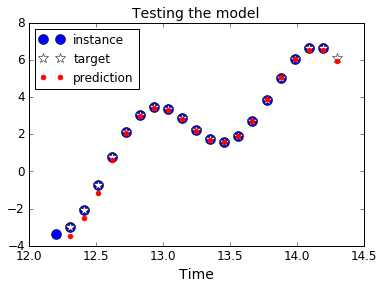

In [37]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

0 	MSE: 14167.3
100 	MSE: 480.774
200 	MSE: 194.57
300 	MSE: 66.9419
400 	MSE: 79.4116
500 	MSE: 46.7239
600 	MSE: 48.8176
700 	MSE: 45.1877
800 	MSE: 46.8532
900 	MSE: 39.5473
1000 	MSE: 46.5509
1100 	MSE: 45.1024
1200 	MSE: 48.5357
1300 	MSE: 38.5474
1400 	MSE: 49.4831
1500 	MSE: 45.0398
1600 	MSE: 50.1059
1700 	MSE: 44.9415
1800 	MSE: 42.2207
1900 	MSE: 49.906


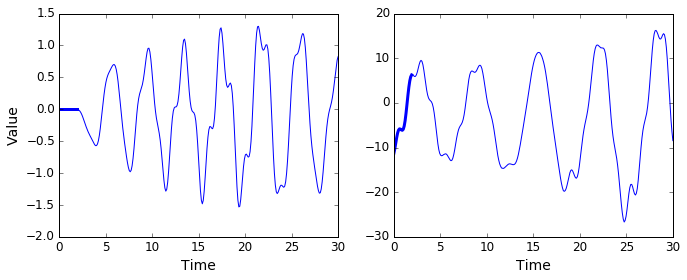

In [38]:
n_iterations = 2000
batch_size = 50
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [39]:
tf.reset_default_graph()

n_inputs = 2
n_neurons = 100
n_layers = 3
n_steps = 5
keep_prob = 0.5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([basic_cell] * n_layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [40]:
X_batch = rnd.rand(2, n_steps, n_inputs)

In [41]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [42]:
outputs_val.shape

(2, 5, 100)

## Dropout

In [43]:
tf.reset_default_graph()
from tensorflow.contrib.layers import fully_connected

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

keep_prob = 0.5
learning_rate = 0.001

is_training = True

def deep_rnn_with_dropout(X, y, is_training):
    cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell] * n_layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = fully_connected(stacked_rnn_outputs, n_outputs, activation_fn=None)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    return outputs, loss, training_op

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [44]:
n_iterations = 2000
batch_size = 50

with tf.Session() as sess:
    if is_training:
        init.run()
        for iteration in range(n_iterations):
            X_batch, y_batch = next_batch(batch_size, n_steps)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 100 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    else:
        saver.restore(sess, "/tmp/my_model.ckpt")
        X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
        plt.title("Testing the model", fontsize=14)
        plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
        plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
        plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.show()

0 	MSE: 13446.5
100 	MSE: 6108.62
200 	MSE: 4628.27
300 	MSE: 4554.2
400 	MSE: 3862.41
500 	MSE: 3427.27
600 	MSE: 2879.59
700 	MSE: 3460.99
800 	MSE: 2547.23
900 	MSE: 2595.12
1000 	MSE: 2987.26
1100 	MSE: 2284.86
1200 	MSE: 2123.55
1300 	MSE: 2566.21
1400 	MSE: 2494.94
1500 	MSE: 2439.69
1600 	MSE: 2611.02
1700 	MSE: 2650.31
1800 	MSE: 2597.95
1900 	MSE: 2258.47


# LSTM

In [45]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
multi_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell]*3)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = fully_connected(top_layer_h_state, n_outputs, activation_fn=None, scope="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [46]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>))

In [47]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>

In [48]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.966667 Test accuracy = 0.9486
Epoch 1 Train accuracy = 0.993333 Test accuracy = 0.9685
Epoch 2 Train accuracy = 0.946667 Test accuracy = 0.9766
Epoch 3 Train accuracy = 0.986667 Test accuracy = 0.9768
Epoch 4 Train accuracy = 0.98 Test accuracy = 0.9758
Epoch 5 Train accuracy = 1.0 Test accuracy = 0.9835
Epoch 6 Train accuracy = 0.986667 Test accuracy = 0.9876
Epoch 7 Train accuracy = 1.0 Test accuracy = 0.9851
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9865
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9882


# Distributing layers across devices

In [49]:
import tensorflow as tf

class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [50]:
tf.reset_default_graph()

n_inputs = 5
n_neurons = 100
devices = ["/cpu:0"]*5
n_steps = 20
X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])
lstm_cells = [DeviceCellWrapper(device, tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
              for device in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

In [51]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: rnd.rand(2, n_steps, n_inputs)}))

[[[-0.01708752 -0.00816594 -0.08531895 ...,  0.01293303 -0.03598548
    0.00492087]
  [-0.09519478 -0.00846841 -0.10969562 ...,  0.05941417  0.04731981
    0.09693822]
  [-0.14912453 -0.10635467 -0.12964553 ..., -0.01562085 -0.04393777
   -0.05746868]
  ..., 
  [-0.24811372 -0.02024984 -0.22714953 ...,  0.02804995 -0.0127665
   -0.09021875]
  [-0.24003756 -0.16685337 -0.15991297 ..., -0.28325534 -0.12053813
    0.02008178]
  [-0.26741144 -0.00421038 -0.57989764 ..., -0.11607802  0.15951051
    0.13105012]]

 [[-0.03169292  0.01983191 -0.08063509 ...,  0.01142524 -0.07150294
   -0.01657837]
  [-0.23104219  0.06165724 -0.11865821 ...,  0.01108671  0.02383714
    0.09903613]
  [-0.16916461 -0.13944981 -0.19668107 ..., -0.01075597 -0.09825428
   -0.10360008]
  ..., 
  [-0.10707516  0.15896417 -0.06263893 ..., -0.05023656 -0.06619275
   -0.1176419 ]
  [-0.2273972   0.0458602  -0.34042427 ..., -0.3957144   0.02994739
    0.17840534]
  [-0.28331926 -0.08697947 -0.37225938 ..., -0.44854224  0.

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [7]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [8]:
words = fetch_words_data()

In [9]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [10]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [11]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5236, 3081,   12,    6,  195,    2, 3135,   46,   59]))

In [12]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'guided originated as a term of extinct first used'

In [13]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [14]:
import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [15]:
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [16]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [17]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5236],
        [   6],
        [3081],
        [ 195],
        [  12],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a'])

## Build the model

In [18]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = rnd.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [19]:
tf.reset_default_graph()

# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Look up embeddings for inputs.
init_embeddings = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeddings)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [20]:
num_steps = 100001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  251.248123169
Nearest to people: anchors, tests, satisfactorily, erg, brasilia, administered, assistants, quays,
Nearest to can: jenny, proliferate, elusive, utility, dieting, toms, affecting, scrambled,
Nearest to than: troika, lane, shrink, medi, narrator, rin, rides, alces,
Nearest to its: ritual, columbia, precludes, besieged, hunmin, vis, mandan, microsystems,
Nearest to their: antioxidants, syme, conformity, trousers, stature, rapier, personhood, rinks,
Nearest to have: hiragana, abstained, grid, conti, gender, corner, agade, consequent,
Nearest to six: expansions, millionaires, checker, colonized, profound, hydrogenation, thermoregulation, bootleg,
Nearest to over: hapless, draugr, mark, dre, surgically, forgery, maximise, cyril,
Nearest to two: anagram, evenings, eee, brutus, buyer, addons, bam, guattari,
Nearest to UNK: cornwell, selina, ericaceae, browed, blake, biostatistics, cages, penetrates,
Nearest to was: strains, currents, caligu

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [21]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [22]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

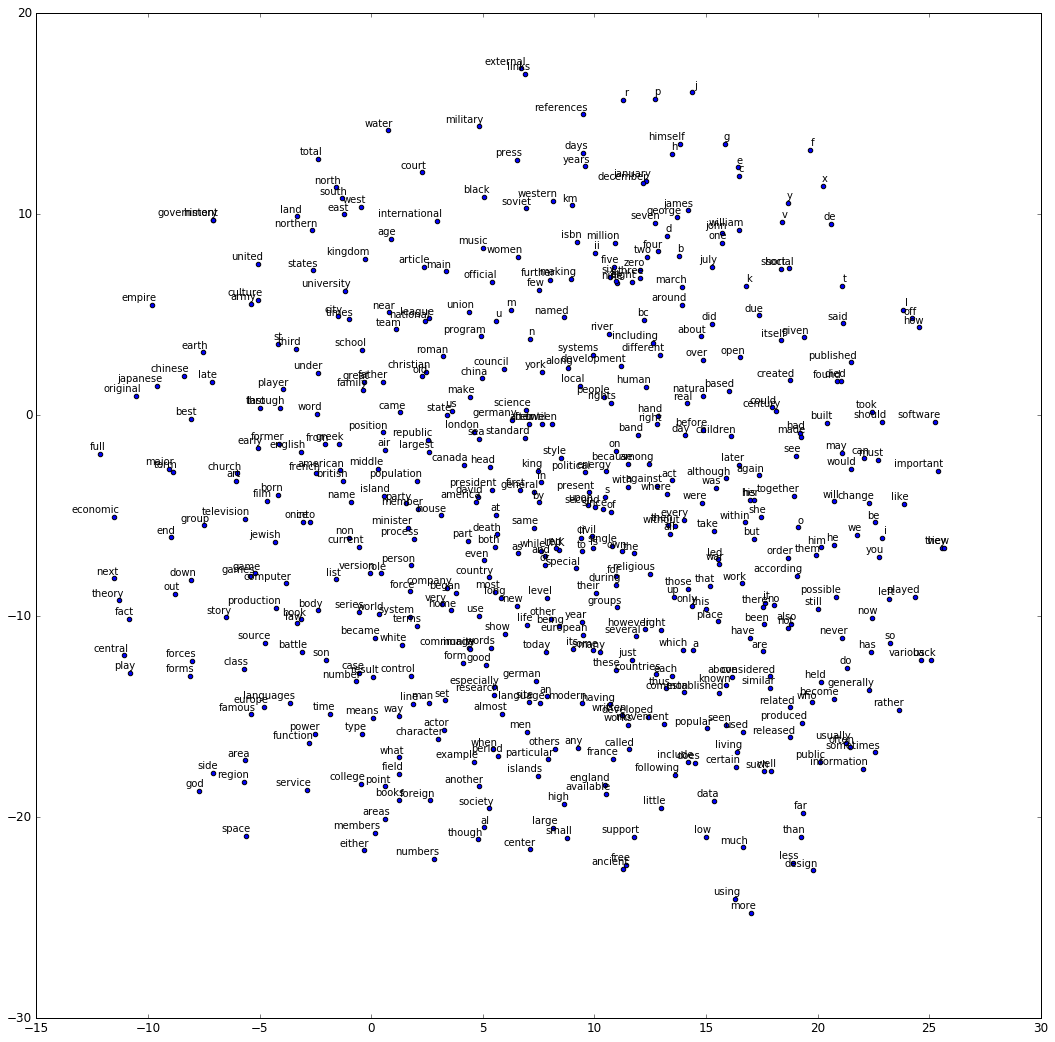

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [24]:
import tensorflow as tf
tf.reset_default_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * n_layers)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [25]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

**Coming soon**